I am heavily referring to https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8 for this notebook.
Using KerasCNN, model adapted from https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution

In [2]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import platform
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
import tensorflow as tf

Using TensorFlow backend.


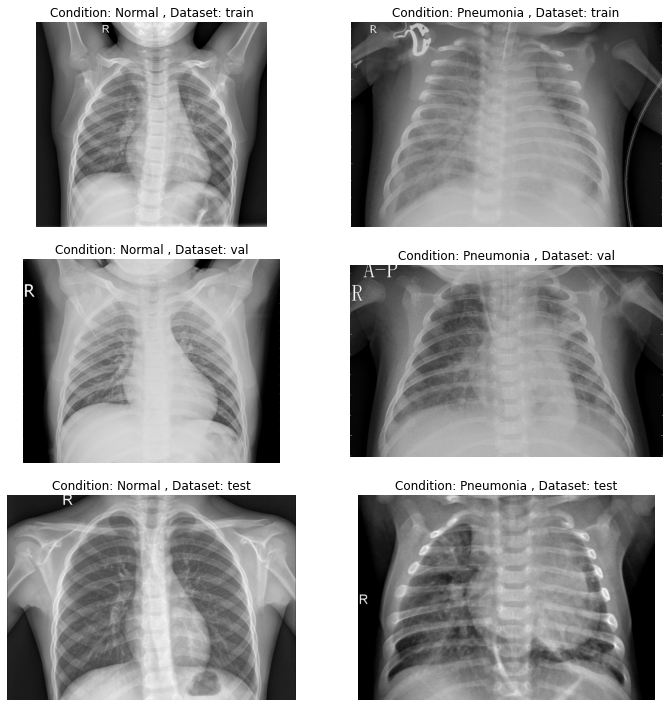

In [3]:
### System Settings ###
pdiv = "/" if platform.system() == "Windows" else "\\"

### Visualising the Dataset ###
#fig, axarr = plt.subplots(2, 3, figsize=(13, 7)) #Horizontal Arrangement
fig, axarr = plt.subplots(3, 2, figsize=(10,10)) #Vertical Arrangement
plt.tight_layout()
path = ".{}chest_xray{}".format(pdiv,pdiv)


## We Grayscale the images to better spot the differences ###
#Horizontal Arrangement
#for i, _set in enumerate(['train', 'val', 'test']):
#    axarr[0,i].imshow(plt.imread(path+_set+pdiv+'NORMAL'+pdiv+os.listdir(path+_set+pdiv+'NORMAL')[0]), cmap='gray')
#    axarr[0,i].set_title('Condition: Normal , Dataset: {}'.format(_set))
#    axarr[0,i].axis('off')
#    axarr[1,i].imshow(plt.imread(path+_set+pdiv+'PNEUMONIA'+pdiv+os.listdir(path+_set+pdiv+'PNEUMONIA')[0]), cmap='gray')
#    axarr[1,i].set_title('Condition: Pneumonia , Dataset: {}'.format(_set))
#    axarr[1,i].axis('off')

#Vertical Arrangement
for i, _set in enumerate(['train', 'val', 'test']):
    axarr[i,0].imshow(plt.imread(path+_set+pdiv+'NORMAL'+pdiv+os.listdir(path+_set+pdiv+'NORMAL')[0]), cmap='gray')
    axarr[i,0].set_title('Condition: Normal , Dataset: {}'.format(_set))
    axarr[i,0].axis('off')
    axarr[i,1].imshow(plt.imread(path+_set+pdiv+'PNEUMONIA'+pdiv+os.listdir(path+_set+pdiv+'PNEUMONIA')[0]), cmap='gray')
    axarr[i,1].set_title('Condition: Pneumonia , Dataset: {}'.format(_set))
    axarr[i,1].axis('off')

It is evident that the differences between a "Normal" and a "Pneumonia" chest-X-ray are highly similar, with the differences being very difficult to identify. A professional trained Radiologist takes anywhere from 15 minutes to an hour to identify and classify the patients into either "Normal" or "Pneumonia"

In [4]:
### Inspecting the Dataset ###

for _dataset in ['train', 'val', 'test']:
    num_normal = len(os.listdir(path + _dataset + '/NORMAL'))
    num_pneu = len(os.listdir(path + _dataset + '/PNEUMONIA'))
    print('Set: {}, No. of Normal Images: {}, No. of Pneumonia images: {}'.format(_dataset, num_normal, num_pneu))

Set: train, No. of Normal Images: 1341, No. of Pneumonia images: 3875
Set: val, No. of Normal Images: 8, No. of Pneumonia images: 8
Set: test, No. of Normal Images: 234, No. of Pneumonia images: 390


We observe that the number of Normal images are far fewer than the number of Pneumonia images in the training set. This means that we have to create our own data, or data augmentation to produce more training data.

In [ ]:
### SMOTE ###
### HANDLE IMBALANCED DATA ###
from collections import Counter
from imblearn.over_sampling import SMOTE, RandomOverSampler, KMeansSMOTE, BorderlineSMOTE

# Transform the dataset
# oversample = SMOTE(sampling_strategy='auto', k_neighbors=8, random_state=100)
# oversample = KMeansSMOTE(sampling_strategy='auto', k_neighbors=8, random_state=100)
# oversample = RandomOverSampler(random_state=42)
oversample = BorderlineSMOTE(random_state=100)
data_train, label_train = oversample.fit_resample(data_train.reshape(data_train.shape[0], -1), label_train)
data_train = data_train.reshape(data_train.shape[0], dimension[0], dimension[1], dimension[2])


In [5]:
### Data Augmentation/Generation ##
def data_gen(img_height, img_width, batch_size):
    train_datagen = ImageDataGenerator(rescale=1./255, vertical_flip=True, rotation_range=20, brightness_range=(1.1,1.3))
    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(
        directory = path+'train',
        target_size = (img_height, img_width),
        class_mode = 'binary',
        batch_size = batch_size,
        shuffle = True
    )
    
    val_gen = val_datagen.flow_from_directory(
        directory = path+'val',
        target_size = (img_height, img_width),
        class_mode = 'binary',
        batch_size = batch_size,
        shuffle = True
    )
    
    test_gen = test_datagen.flow_from_directory(
        directory = path+'test',
        target_size = (img_height, img_width),
        class_mode = 'binary',
        batch_size = batch_size,
        shuffle = True
    )
    
    return train_gen, val_gen, test_gen

In [38]:
img_height = 200 #or 224
img_width = 200 #or 224
batch_size = 32
num_epochs = 10

train_gen, val_gen, test_gen = data_gen(img_height, img_width, batch_size)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
### TODO: Create Class Labels for images ###

In [39]:
### Building the Model ###
def model_builder_kcnn():
    input_img = Input(shape=(img_height, img_width, 3))
    
    x = Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(input_img)
    x = Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    
    x = SeparableConv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    
    x = SeparableConv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = SeparableConv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = SeparableConv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    
    x = SeparableConv2D(filters=256, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = SeparableConv2D(filters=256, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.2)(x) #to reduce overfitting
    
    x = SeparableConv2D(filters=512, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = SeparableConv2D(filters=512, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.2)(x) #to reduce overfitting
    
    x = Flatten()(x)
    x = Dense(units=1024, activation='relu')(x)
    x = Dropout(0.6)(x)
    x = Dense(units=256, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(units=16, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [40]:
### Training the model ###
model_kcnn = model_builder_kcnn()
model_kcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#To reduce overfitting, have callbacks
checkpt = ModelCheckpoint(filepath='best_model_time', save_best_only=True, save_weights_only=True)
early_stop = EarlyStopping(patience=5)

checkpt = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

model_kcnn_hist = model_kcnn.fit_generator(
    train_gen, steps_per_epoch=train_gen.samples//batch_size, 
    epochs=num_epochs, validation_data=val_gen, validation_steps=val_gen.samples // batch_size,
    callbacks=[checkpt, lr_reduce])

Epoch 1/10
163/163 [==============================] - 92s 566ms/step - loss: 0.3238 - accuracy: 0.8595 - val_loss: 1.0800 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 91s 558ms/step - loss: 0.2612 - accuracy: 0.8934 - val_loss: 1.1752 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 91s 558ms/step - loss: 0.2496 - accuracy: 0.8961 - val_loss: 0.7181 - val_accuracy: 0.5000
Epoch 4/10
163/163 [==============================] - 91s 557ms/step - loss: 0.2437 - accuracy: 0.9047 - val_loss: 1.0984 - val_accuracy: 0.5000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/10
163/163 [==============================] - 92s 565ms/step - loss: 0.2044 - accuracy: 0.9247 - val_loss: 19.0682 - val_accuracy: 0.5000
Epoch 6/10
163/163 [==============================] - 95s 582ms/step - loss: 0.1790 - accuracy: 0.9294 - val_loss: 0.7288 - val_accuracy: 0.6250
Epoch 7/10
163/163 [============================

Plot the Loss and Accuracy to visualise across epochs

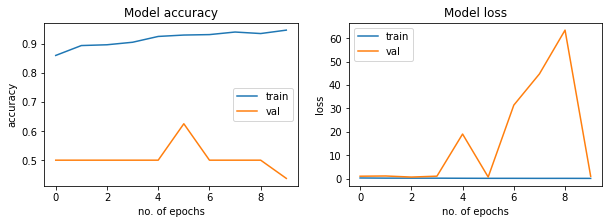

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, val in enumerate(['accuracy', 'loss']):
    ax[i].plot(model_kcnn_hist.history[val])
    ax[i].plot(model_kcnn_hist.history['val_' + val])
    ax[i].set_title('Model {}'.format(val))
    ax[i].set_xlabel('no. of epochs')
    ax[i].set_ylabel(val)
    ax[i].legend(['train', 'val'])

In [42]:
### Preparing the Test Data ###
test_data = []
test_labels = []

for cond in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(path+'test'+cond)):
        img = plt.imread(path+'test'+cond+img)
        img = cv2.resize(img, (img_height, img_width))
        img = np.dstack([img, img, img])
        img = img.astype(np.float32)/255
        test_data.append(img)
        if cond == '/NORMAL/':
            #label = to_categorical(0, num_classes=2)
            #test_labels.append(label)
            test_labels.append(0)
        elif cond == '/PNEUMONIA/':
            #label = to_categorical(1, num_classes=2)
            #test_labels.append(1)
            test_labels.append(1)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Number of Test Data: ", test_data.shape)
print("Number of Test Labels: ", test_labels.shape)

Number of Test Data:  (624, 200, 200, 3)
Number of Test Labels:  (624,)


In [43]:
### Predictions on Test Set ###
predict = model_kcnn.predict(test_data)

cm = confusion_matrix(test_labels, np.round(predict))
print(cm)

[[ 92 142]
 [  0 390]]


To check how good our trained model is, we will check the Recall and Precision of our model

$Recall = \frac{True Positives}{True Positives + False Negatives}$

$Precision = \frac{True Positives}{True Positives + False Positives}$

For predicting pneumonia, we should aim to maximise Recall as the complications caused by incorrectly classifying a pneumonia case as a normal case is much more deadly than a normal case being classified as a pneumonia case. With the former being possibly deadly to the incorrectly labelled individual while the latter will soon be spotted by medical staff and corrected.

Plot the Confusion Matrix to calculate the Recall and the Precision

In [44]:
### Confusion Matrix ###
cm = confusion_matrix(test_labels, np.round(predict))
tn, fp, fn, tp = cm.ravel()
acc = accuracy_score(test_labels, np.round(predict))*100

print('### CONFUSION MATRIX ###')
print(cm)

### Calculate Recall and Precision ###
print('\n ### TEST METRICS ###')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))


### CONFUSION MATRIX ###
[[ 92 142]
 [  0 390]]

 ### TEST METRICS ###
Accuracy: 77.24358974358975%
Precision: 73.30827067669173%
Recall: 100.0%
F1-score: 84.59869848156183
